# Exploring United States Policing Data Using Python

The intersection of science, politics, personal opinion, and social policy can be rather complex.  This junction of ideas and disciplines is often rife with controversies, strongly held viewpoints, and agendas that are often [more based on belief than on empirical evidence](https://en.wikipedia.org/wiki/Global_warming_controversy).  Data science is particularly important in this area since it provides a methodology for examining the world in a pragmatic fact-first manner, and is capable of providing insight into some of the most important issues that we face today.

The recent high-profile police shootings of unarmed black men, such as [Michael Brown](https://en.wikipedia.org/wiki/Shooting_of_Michael_Brown) (2014), [Tamir Rice](https://en.wikipedia.org/wiki/Shooting_of_Tamir_Rice) (2014), [Anton Sterling](https://en.wikipedia.org/wiki/Shooting_of_Alton_Sterling) (2016), and [Philando Castile](https://en.wikipedia.org/wiki/Shooting_of_Philando_Castile) (2016), have triggered a divisive national dialog on the issue of racial bias in policing.

These shootings have spurred the growth of large social movements seeking to raise awareness of what is viewed as the systemic targeting of people-of-color by police forces across the country.  On the other side of the political spectrum, many hold a view that the unbalanced targeting of non-white citizens is a myth created by the media based on a handful of extreme cases, and that these highly-publicized stories are not representative of the national norm.

In June 2017, a team of researchers at Stanford University collected and released an open-source data set of 60 million state police patrol stops from 20 states across the US.  In this tutorial, we will walk through how to analyze and visualize this data using Python.

![county scatters vt](https://cdn.patricktriest.com/blog/images/posts/policing-data/county_scatter_VT.png)

The source code and figures for this analysis can be found in the companion Github repository - https://github.com/triestpa/Police-Analysis-Python

To preview the completed IPython notebook, visit the page [here](https://github.com/triestpa/Police-Analysis-Python/blob/master/traffic_stop_analysis.ipynb).

> This tutorial and analysis would not be possible without the work performed by [The Standford Open Policing Project](https://openpolicing.stanford.edu/).  Much of the analysis performed in this tutorial is based on the work that has already performed by this team.  [A short tutorial](https://openpolicing.stanford.edu/tutorials/) for working with the data using the R programming language is provided on the official project website.


In the United States there are more than 50,000 traffic stops on a typical day.  The potential number of data points for each stop is huge, from the demographics (age, race, gender) of the driver, to the location, time of day, stop reason, stop outcome, car model, and much more.  Unfortunately, not every state makes this data available, and those that do often have different standards for which information is reported.  Different counties and districts within each state can also be inconstant in how each traffic stop is recorded.  The [research team at Stanford](https://openpolicing.stanford.edu/) has managed to gather traffic-stop data from twenty states, and has worked to regularize the reporting standards for 11 fields.

- Stop Date
- Stop Time
- Stop Location
- Driver Race
- Driver Gender
- Driver Age
- Stop Reason
- Search Conducted
- Search Type
- Contraband Found
- Stop Outcome

Most states do not have data available for every field, but there is enough overlap between the data sets to provide a solid foundation for some very interesting analysis.


# Project Setup

We'll need to install a few Python packages to perform our analysis.

On the command line, run the following command to install the required libraries.
```bash
pip install numpy pandas matplotlib ipython jupyter
```

> If you're using Anaconda, you can replace the `pip` command here with `conda`.  Also, depending on your installation, you might need to use `pip3` instead of `pip` in order to install the Python 3 versions of the packages.


In the first cell of the notebook, import our dependencies.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
figsize = (16,8)

We're also setting a shared variable `figsize` that we'll reuse later on in our data visualization logic.

# Dataset Exploration

We'll start with analyzing the data set for Vermont.  We're looking at Vermont first for a few reasons.

1. The Vermont dataset is small enough to be very manageable and quick to operate on, with only 283,285 traffic stops (compared to the Texas data set, for instance, which contains almost 24 million records).
1. There is not much missing data, as all eleven fields mentioned above are covered.
1. Vermont is 94% white, but is also in a part of the country known for being very liberal (disclaimer - I grew up in the Boston area, and I've spent a quite a bit of time in Vermont).  Many in this area consider this state to be very progressive and might like to believe that their state institutions are not as prone to systemic racism as the institutions in other parts of the country.  It will be interesting to determine if the data validates this view.

First, download the Vermont traffic stop data - https://stacks.stanford.edu/file/druid:py883nd2578/VT-clean.csv.gz

## Load Dataset

Load Vermont police stop data set into a [Pandas dataframe](https://pandas.pydata.org/pandas-docs/stable/dsintro.html#dataframe).

In [3]:
df_vt = pd.read_csv('./data/VT-clean.csv.gz', compression='gzip', low_memory=False)

> This command assumes that you are storing the data set in the `data` directory of the project.  If you are not, you can adjust the data file path accordingly.

We can get a quick preview of the first ten rows of the data set with the `head()` method.

In [4]:
df_vt.head()

,id,state,stop_date,stop_time,location_raw,county_name,county_fips,fine_grained_location,police_department,driver_gender,...,driver_race,violation_raw,violation,search_conducted,search_type_raw,search_type,contraband_found,stop_outcome,is_arrested,officer_id
0,VT-2010-00001,VT,2010-07-01,00:10,East Montpelier,Washington County,50023.0,COUNTY RD,MIDDLESEX VSP,M,...,White,Moving Violation,Moving violation,False,No Search Conducted,NaN,False,Citation,False,-1.562157e+09
1,VT-2010-00002,VT,2010-07-01,00:10,NaN,NaN,NaN,COUNTY RD; Fitch Road,MIDDLESEX VSP,F,...,White,Externally Generated Stop,Other,False,No Search Conducted,NaN,False,Arrest for Violation,True,-1.562157e+09
2,VT-2010-00003,VT,2010-07-01,00:10,NaN,NaN,NaN,COUNTY RD; Fitch Road,MIDDLESEX VSP,F,...,White,Externally Generated Stop,Other,False,No Search Conducted,NaN,False,Arrest for Violation,True,-1.562157e+09
3,VT-2010-00004,VT,2010-07-01,00:11,Whiting,Addison County,50001.0,N MAIN ST,NEW HAVEN VSP,F,...,White,Moving Violation,Moving violation,False,No Search Conducted,NaN,False,Arrest for Violation,True,-3.126844e+08
4,VT-2010-00005,VT,2010-07-01,00:35,Hardwick,Caledonia County,50005.0,i91 nb mm 62,ROYALTON VSP,M,...,White,Moving Violation,Moving violation,False,No Search Conducted,NaN,False,Written Warning,False,9.225661e+08


We can also list the available fields by reading the `columns` property.

In [5]:
df_vt.columns

Index(['id', 'state', 'stop_date', 'stop_time', 'location_raw', 'county_name',
       'county_fips', 'fine_grained_location', 'police_department',
       'driver_gender', 'driver_age_raw', 'driver_age', 'driver_race_raw',
       'driver_race', 'violation_raw', 'violation', 'search_conducted',
       'search_type_raw', 'search_type', 'contraband_found', 'stop_outcome',
       'is_arrested', 'officer_id'],
      dtype='object')

## Clean Dataset

Let's do a quick count of each column to determine how consistently populated the data is.

In [6]:
df_vt.count()

id                       283285
state                    283285
stop_date                283285
stop_time                283285
location_raw             282591
county_name              282580
county_fips              282580
fine_grained_location    282938
police_department        283285
driver_gender            281573
driver_age_raw           282114
driver_age               281999
driver_race_raw          279301
driver_race              278468
violation_raw            281107
violation                281107
search_conducted         283285
search_type_raw          281045
search_type                3419
contraband_found         283251
stop_outcome             280960
is_arrested              283285
officer_id               283273
dtype: int64

We can see that most columns have similar numbers of values besides `search_type`, which is not present for most of the rows, likely because most stops do not result in a search.

For our analysis, it will be best to have the exact same number of values for each field.  We'll go ahead now and make sure that every single cell has a value.

In [7]:
# Fill missing search type values with placeholder
df_vt['search_type'].fillna('N/A', inplace=True)

# Drop rows with missing values
df_vt.dropna(inplace=True)

When we count the values again, we'll see that each column has the exact same number of entries.

In [8]:
df_vt.count()

id                       273181
state                    273181
stop_date                273181
stop_time                273181
location_raw             273181
county_name              273181
county_fips              273181
fine_grained_location    273181
police_department        273181
driver_gender            273181
driver_age_raw           273181
driver_age               273181
driver_race_raw          273181
driver_race              273181
violation_raw            273181
violation                273181
search_conducted         273181
search_type_raw          273181
search_type              273181
contraband_found         273181
stop_outcome             273181
is_arrested              273181
officer_id               273181
dtype: int64

## Stops By County

Let's get a list of all counties in the data set, along with how many traffic stops happened in each.

In [9]:
df_vt['county_name'].value_counts()

Windham County       37715
Windsor County       36464
Chittenden County    24815
Orange County        24679
Washington County    24633
Rutland County       22885
Addison County       22813
Bennington County    22250
Franklin County      19715
Caledonia County     16505
Orleans County       10344
Lamoille County       8604
Essex County          1239
Grand Isle County      520
Name: county_name, dtype: int64

If you're familiar with Vermont's geography, you'll notice that the police stops seem to be more concentrated in counties in the southern-half of the state.  The southern-half of the state is also where much of the cross-state traffic flows in transit to and from New Hampshire, Massachusetts, and New York.  Since the traffic stop data is from the state troopers, this interstate highway traffic could potentially explain why we see more traffic stops in these counties.

Here's a quick map generated with [Tableau](https://public.tableau.com/profile/patrick.triest#!/vizhome/VtPoliceStops/Sheet1) to visualize this regional distribution.

![Vermont County Map](https://cdn.patricktriest.com/blog/images/posts/policing-data/vermont_map.png)

## Violations

We can also check out the distribution of traffic stop reasons.

In [10]:
df_vt['violation_raw'].value_counts()

Moving Violation              212100
Vehicle Equipment              50600
Externally Generated Stop       6160
Investigatory Stop              3608
Suspicion of DWI                 711
(Winooski) Be On Look Rqst         1
(Winooski) Mtr Vhc Vltn            1
Name: violation_raw, dtype: int64

In [11]:
df_vt['violation'].value_counts()

Moving violation      212100
Equipment              50600
Other                   9768
DUI                      711
Other (non-mapped)         2
Name: violation, dtype: int64

Unsurprisingly, the top reason for a traffic stop is `Moving Violation` (speeding, reckless driving, etc.), followed by `Equipment` (faulty lights, illegal modifications, etc.).

By using the `violation_raw` fields as reference, we can see that the `Other` category includes "Investigatory Stop" (the police have reason to suspect that the driver of the vehicle has committed a crime) and  "Externally Generated Stop" (possibly as a result of a 911 call, or a referral from municipal police departments).

`DUI` ("driving under the influence", i.e. drunk driving) is surprisingly the least prevalent, with only 711 total recorded stops for this reason over the five year period (2010-2015) that the dataset covers.  This seems low, since [Vermont had 2,647 DUI arrests in 2015](http://www.statisticbrain.com/number-of-dui-arrests-per-state/), so I suspect that a large proportion of these arrests were performed by municipal police departments, and/or began with a `Moving Violation` stop, instead of a more specific `DUI` stop.

## Stop Outcomes

We can also examine the traffic stop outcomes.

In [12]:
df_vt['stop_outcome'].value_counts()

Written Warning         166488
Citation                103401
Arrest for Violation      3206
Warrant Arrest              76
Verbal Warning              10
Name: stop_outcome, dtype: int64

A majority of stops result in a written warning - which goes on the record but carries no direct penalty.  A bit over 1/3 of the stops result in a citation (commonly known as a ticket), which comes with a direct fine and can carry other negative side-effects such as raising a driver's auto insurance premiums.

The decision to give a warning or a citation is often at the discretion of the police officer, so this could be a good source for studying bias.

## Stops By Gender

Let's break down the traffic stops by gender.

In [13]:
df_vt['driver_gender'].value_counts()

M    174070
F     99111
Name: driver_gender, dtype: int64

We can see that approximately 36% of the stops are of women drivers, and 64% are of men.

## Stops By Race

Let's also examine the distribution by race.

In [14]:
df_vt['driver_race'].value_counts()

White       261339
Black         5571
Asian         3446
Hispanic      2562
Other          263
Name: driver_race, dtype: int64

Most traffic stops are of white drivers, which is to be expected since [Vermont is around 94% white](https://www.census.gov/quickfacts/VT) (making it the 2nd-least diverse state in the nation, [behind Maine](https://www.census.gov/quickfacts/ME)).  Since white drivers make up approximately 94% of the traffic stops, there's no obvious bias here for pulling over non-white drivers vs white drivers.  Using the same methodology, however, we can also see that while black drivers make up roughly 2% of all traffic stops, [only 1.3% of Vermont's population is black](https://www.census.gov/quickfacts/VT).

Let's keep on analyzing the data to see what else we can learn.

## Stop Frequency by Race and Age

It would be interesting to visualize how the frequency of police stops breaks down by both race and age.

In [15]:
df_vt = df_vt[df_vt['driver_race'] != 'Other']

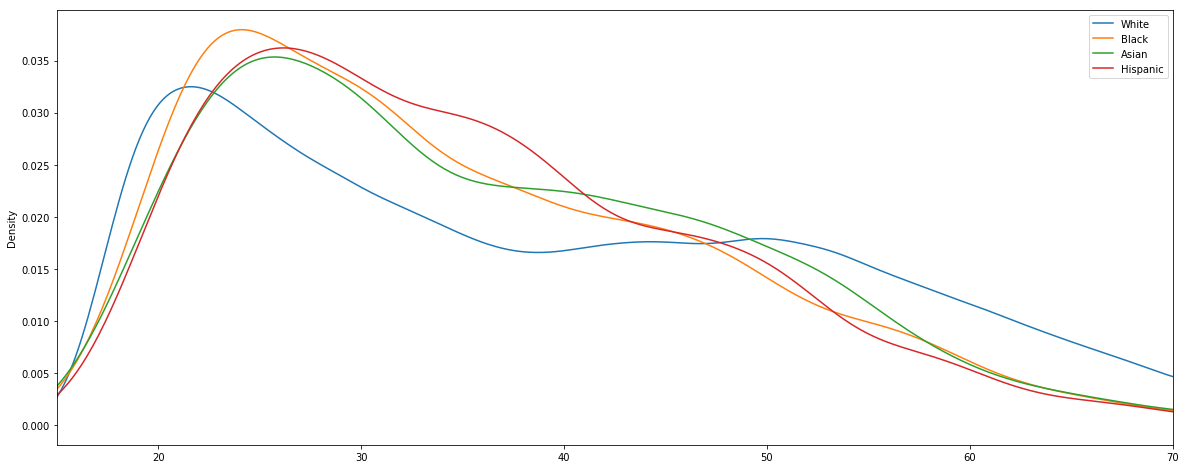

In [16]:
fig, ax = plt.subplots(figsize=(20,8))
ax.set_xlim(15, 70)
for race in df_vt['driver_race'].unique():
    s = df_vt[df_vt['driver_race'] == race]['driver_age']
    s.plot.kde(ax=ax, label=race)
ax.legend()

# fig.savefig('images/race_age_dist.png', bbox_inches='tight')

We can see that young drivers in their late teens and early twenties are the most likely to be pulled over.  Between ages 25 and 35, the stop rate of each demographic drops off quickly. As far as the racial comparison goes, the most interesting disparity is that for white drivers between the ages of 35 and 50 the pull-over rate stays mostly flat, whereas for other races it continues to drop steadily.

# Analyze Violation and Outcome Data

Now that we've got a feel for the dataset, we can start getting into some more advanced analysis.

One interesting topic that we touched on earlier is the fact that the decision to penalize a driver with a ticket or a citation is often at the discretion of the police officer.  With this in mind, let's see if there are any discernable patterns in driver demographics and stop outcome.

## Analysis Helper Function


In order to assist in this analysis, we'll define a helper function to aggregate a few important statistics from our dataset.

- `citations_per_warning` - The ratio of citations to warnings.  A higher number signifies a greater likelihood of being ticketed instead of getting off with a warning.
- `arrest_rate` - The percentage of stops that end in an arrest.

In [17]:
def compute_outcome_stats(df):
    """Compute statistics regarding the relative quanties of arrests, warnings, and citations"""
    n_total = len(df)
    n_warnings = len(df[df['stop_outcome'] == 'Written Warning'])
    n_citations = len(df[df['stop_outcome'] == 'Citation'])
    n_arrests = len(df[df['stop_outcome'] == 'Arrest for Violation'])
    citations_per_warning = n_citations / n_warnings
    arrest_rate = n_arrests / n_total
    
    return(pd.Series(data = { 
        'n_total': n_total,
        'n_warnings': n_warnings,
        'n_citations': n_citations,
        'n_arrests': n_arrests,
        'citations_per_warning': citations_per_warning,
        'arrest_rate': arrest_rate
    }))

Let's test out this helper function by applying it to the entire dataframe.

In [18]:
compute_outcome_stats(df_vt)

arrest_rate                   0.011721
citations_per_warning         0.620751
n_arrests                  3199.000000
n_citations              103270.000000
n_total                  272918.000000
n_warnings               166363.000000
dtype: float64

In the above result, we can see that about `1.17%` of traffic stops result in an arrest, and there are on-average `0.62` citations (tickets) issued per warning.  This data passes the sanity check, but it's too coarse to provide many interesting insights.  Let's dig deeper.

## Breakdown By Gender

Using our helper function, along with the Pandas dataframe [groupby](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.groupby.html) method, we can easily compare these stats for male and female drivers.

In [19]:
df_vt.groupby('driver_gender').apply(compute_outcome_stats)

,arrest_rate,citations_per_warning,n_arrests,n_citations,n_total,n_warnings
driver_gender,,,,,,
F,0.007038,0.548033,697.0,34805.0,99036.0,63509.0
M,0.014389,0.665652,2502.0,68465.0,173882.0,102854.0


This is a simple example of the common [split-apply-combine](https://pandas.pydata.org/pandas-docs/stable/groupby.html) technique.  We'll be building on this pattern for the remainder of the tutorial, so make sure that you understand how this comparison table is generated before continuing.

We can see here that men are, on average, twice as likely to be arrested during a traffic stop, and are also slightly more likely to be given a citation than women.  It is, of course, not clear from the data whether this is indicative of any bias by the police officers, or if it reflects that men are being pulled over for more serious offenses than women on average.


## Breakdown By Race

Let's now compute the same comparison, grouping by race.


In [20]:
df_vt.groupby('driver_race').apply(compute_outcome_stats)

,arrest_rate,citations_per_warning,n_arrests,n_citations,n_total,n_warnings
driver_race,,,,,,
Asian,0.006384,1.002339,22.0,1714.0,3446.0,1710.0
Black,0.019925,0.802379,111.0,2428.0,5571.0,3026.0
Hispanic,0.016393,0.865827,42.0,1168.0,2562.0,1349.0
White,0.011571,0.611188,3024.0,97960.0,261339.0,160278.0


Ok, this is interesting.  We can see that Asian drivers are arrested at the lowest rate, but receive tickets at the highest rate (roughly 1 ticket per warning).  Black and Hispanic drivers are both arrested at a higher rate and ticketed at a higher rate than white drivers.


Let's visualize these results.


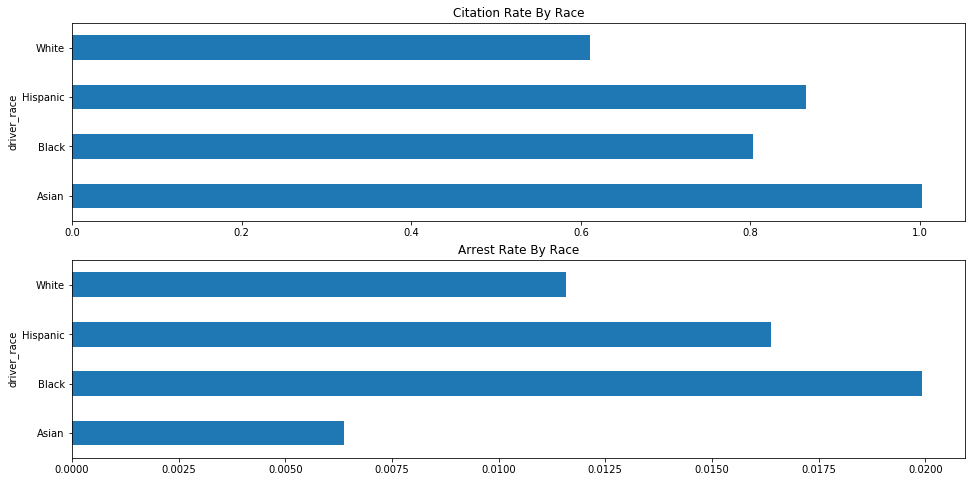

In [21]:
race_agg = df_vt.groupby(['driver_race']).apply(compute_outcome_stats)
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=figsize)
race_agg['citations_per_warning'].plot.barh(ax=axes[0], figsize=figsize, title="Citation Rate By Race")
race_agg['arrest_rate'].plot.barh(ax=axes[1], figsize=figsize, title='Arrest Rate By Race')

# fig.savefig('images/citations_and_arrests_by_race.png', bbox_inches='tight')

## Group By Outcome and Violation

We'll deepen our analysis by grouping each statistic by the violation that triggered the traffic stop.


In [22]:
df_vt.groupby(['driver_race','violation']).apply(compute_outcome_stats)

arrest_rate  citations_per_warning  n_arrests  \
driver_race violation                                                           
Asian       DUI                    0.200000               0.333333        2.0   
            Equipment              0.006270               0.132143        2.0   
            Moving violation       0.005563               1.183190       17.0   
            Other                  0.016393               0.875000        1.0   
Black       DUI                    0.200000               0.142857        2.0   
            Equipment              0.029181               0.220651       26.0   
            Moving violation       0.016052               0.942385       71.0   
            Other                  0.048583               2.205479       12.0   
Hispanic    DUI                    0.200000               3.000000        2.0   
            Equipment              0.023560               0.187898        9.0   
            Moving violation       0.012422               1.058824       26.0   
            Other                  0.064935               1.366667        5.0   
White       DUI                    0.192364               0.455026      131.0   
            Equipment              0.012233               0.190486      599.0   
            Moving violation       0.008635               0.732720     1747.0   
            Other                  0.058378               1.476672      547.0   
            Other (non-mapped)     0.000000               1.000000        0.0   

                                n_citations   n_total  n_warnings  
driver_race violation                                              
Asian       DUI                         2.0      10.0         6.0  
            Equipment                  37.0     319.0       280.0  
            Moving violation         1647.0    3056.0      1392.0  
            Other                      28.0      61.0        32.0  
Black       DUI                         1.0      10.0         7.0  
            Equipment                 156.0     891.0       707.0  
            Moving violation         2110.0    4423.0      2239.0  
            Other                     161.0     247.0        73.0  
Hispanic    DUI                         6.0      10.0         2.0  
            Equipment                  59.0     382.0       314.0  
            Moving violation         1062.0    2093.0      1003.0  
            Other                      41.0      77.0        30.0  
White       DUI                       172.0     681.0       378.0  
            Equipment                7736.0   48965.0     40612.0  
            Moving violation        84797.0  202321.0    115729.0  
            Other                    5254.0    9370.0      3558.0  
            Other (non-mapped)          1.0       2.0         1.0

Ok, well this table looks interesting, but it's rather large and visually overwhelming.  Let's trim down that dataset in order to retrieve a more focused subset of information.


In [23]:
# Create new column to represent whether the driver is White
df_vt['is_white'] = df_vt['driver_race'] == 'White'

# Remove violation with too few data points
df_vt_filtered = df_vt[~df_vt['violation'].isin(['Other (non-mapped)', 'DUI'])]

We're generating a new column to represent whether or not the driver is white.  We are also generating a filtered version of the dataframe that strips out the two violation types with the fewest datapoints.

> We not assigning the filtered dataframe to `df_vt` since we'll want to keep using the complete unfiltered dataset in the next sections.

Let's redo our race + violation aggregation now, using our filtered dataset.


In [24]:
df_vt_filtered.groupby(['is_white','violation']).apply(compute_outcome_stats)

arrest_rate  citations_per_warning  n_arrests  \
is_white violation                                                         
False    Equipment            0.023241               0.193697       37.0   
         Moving violation     0.011910               1.039922      114.0   
         Other                0.046753               1.703704       18.0   
True     Equipment            0.012233               0.190486      599.0   
         Moving violation     0.008635               0.732720     1747.0   
         Other                0.058378               1.476672      547.0   

                           n_citations   n_total  n_warnings  
is_white violation                                            
False    Equipment               252.0    1592.0      1301.0  
         Moving violation       4819.0    9572.0      4634.0  
         Other                   230.0     385.0       135.0  
True     Equipment              7736.0   48965.0     40612.0  
         Moving violation      84797.0  202321.0    115729.0  
         Other                  5254.0    9370.0      3558.0

Ok great, this is much easier to read.

In the above table, we can see that non-white drivers are more likely to be arrested during a stop that was initiated due to an equipment or moving violation, but white drivers are more likely to be arrested for a traffic stop resulting from "Other" reasons.  Non-white drivers are more likely than white drivers to be given tickets for each violation.



## Visualize Stop Outcome and Violation Results

Let's generate a bar chart in order to visualize this data broken down by race.


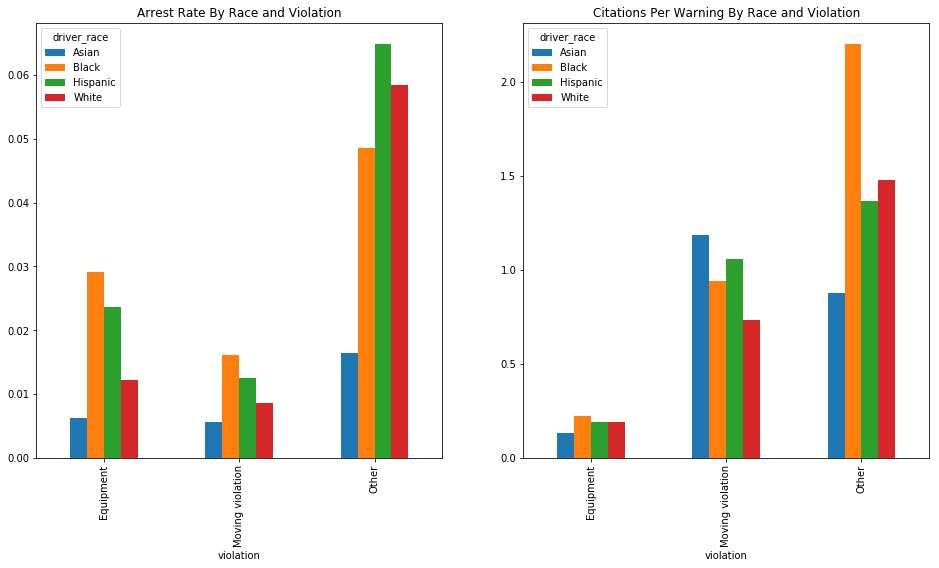

In [25]:
race_stats = df_vt_filtered.groupby(['violation', 'driver_race']).apply(compute_outcome_stats).unstack()
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=figsize)
race_stats.plot.bar(y='arrest_rate', ax=axes[0], title='Arrest Rate By Race and Violation')
race_stats.plot.bar(y='citations_per_warning', ax=axes[1], title='Citations Per Warning By Race and Violation')
                                                       # 
#fig.savefig('images/citations_and_arrests_by_race_and_violation.png', bbox_inches='tight')


We can see in these charts that Hispanic and Black drivers are generally arrested at a higher rate than white drivers (with the exception of the rather ambiguous "Other" category). and  that Black drivers are more likely, across the board, to be issued a citation than white drivers.  Asian drivers are arrested at very low rates, and their citation rates are highly variable.

These results are compelling, and are suggestive of potential racial bias, but they are too inconsistent across violation types to provide any definitive answers.  Let's dig deeper to see what else we can find.


We can easily generate the same visualizations grouped by gender.

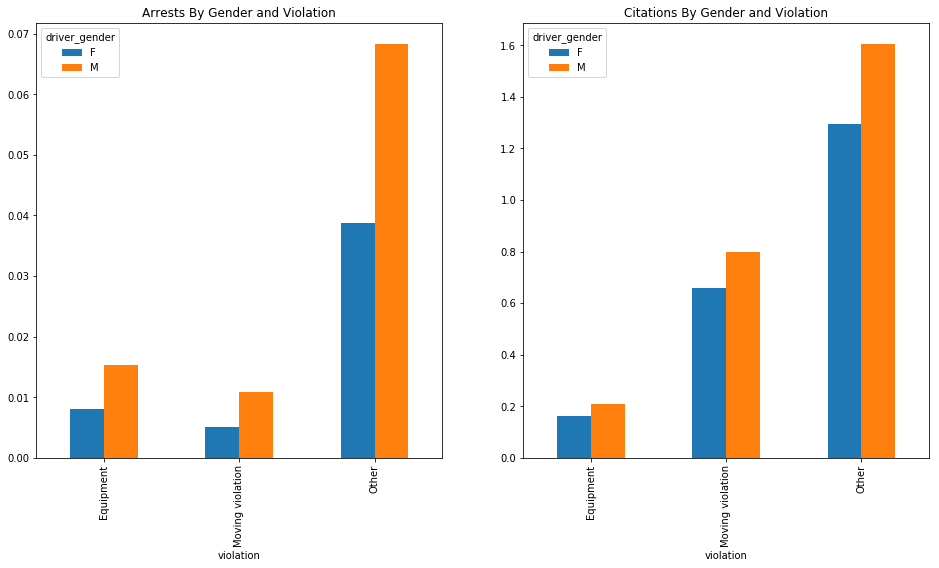

In [26]:
gender_stats = df_vt_filtered.groupby(['violation','driver_gender']).apply(compute_outcome_stats).unstack()
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=figsize)
ax_gender_arrests = gender_stats.plot.bar(y='arrest_rate', ax=axes[0], title='Arrests By Gender and Violation', figsize=figsize)
ax_gender_citations = gender_stats.plot.bar(y='citations_per_warning', ax=axes[1], title='Citations By Gender and Violation', figsize=figsize)

#fig.savefig('images/citations_and_arrests_by_gender_and_violation.png', bbox_inches='tight')

# Search Outcome Analysis

Two of the more interesting fields available to us are `search_conducted` and `contraband_found`.

In the analysis by the "Standford Open Policing Project", they use these two fields to perform what is known as an "outcome test".

On the [project website](https://openpolicing.stanford.edu/findings/), the "outcome test" is summarized clearly.

> In the 1950s, the Nobel prize-winning economist Gary Becker proposed an elegant method to test for bias in search decisions: the outcome test.
>
> Becker proposed looking at search outcomes. If officers don’t discriminate, he argued, they should find contraband — like illegal drugs or weapons — on searched minorities at the same rate as on searched whites. If searches of minorities turn up contraband at lower rates than searches of whites, the outcome test suggests officers are applying a double standard, searching minorities on the basis of less evidence."

[Findings, Stanford Open Policing Project](https://openpolicing.stanford.edu/findings/)

The authors of the project also make the point that only using the "hit rate", or the rate of searches where contraband is found, can be misleading.  For this reason, we'll also need to use the "search rate" in our analysis - the rate at which a traffic stop results in a search.

We'll now use the available data to perform our own outcome test, in order to determine whether minorities in Vermont are routinely searched on the basis of less evidence than white drivers.


## Search Rate and Hit Rate


We'll define a new function to compute the search rate and hit rate for the traffic stops in our dataframe.

- **Search Rate** - The rate at which a traffic stop results in a search.  A search rate of `0.20` would signify that out of 100 traffic stops, 20 resulted in a search.
- **Hit Rate** - The rate at which contraband is found in a search. A hit rate of `0.80` would signify that out of 100 searches, 80 searches resulted in contraband (drugs, unregistered weapons, etc.) being found.


In [27]:
def compute_search_stats(df):
    """Compute the search rate and hit rate"""
    search_conducted = df['search_conducted']
    contraband_found = df['contraband_found']
    n_stops     = len(search_conducted)
    n_searches  = sum(search_conducted)
    n_hits      = sum(contraband_found)
    
    # Filter out counties with too few stops
    if (n_stops) < 50:
        search_rate = None
    else:
        search_rate = n_searches / n_stops
    
    # Filter out counties with too few searches
    if (n_searches) < 5:
        hit_rate = None
    else:
        hit_rate = n_hits / n_searches
    
    return(pd.Series(data = { 
        'n_stops': n_stops,
        'n_searches': n_searches,
        'n_hits': n_hits,
        'search_rate': search_rate,
        'hit_rate': hit_rate
    }))

## Search Stats For Entire Dataset

We can test our new function to determine the search rate and hit rate for the entire state.

In [28]:
compute_search_stats(df_vt)

hit_rate            0.796865
n_hits           2593.000000
n_searches       3254.000000
n_stops        272918.000000
search_rate         0.011923
dtype: float64

Here we can see that each traffic stop had a 1.2% change of resulting in a search, and each search had an 80% chance of yielding contraband.

## Search Stats By Driver Gender

Using the Pandas `groupby` method, we can compute how the search stats differ by gender.

In [29]:
df_vt.groupby('driver_gender').apply(compute_search_stats)

,hit_rate,n_hits,n_searches,n_stops,search_rate
driver_gender,,,,,
F,0.789392,506.0,641.0,99036.0,0.006472
M,0.798699,2087.0,2613.0,173882.0,0.015027


We can see here that men are three times as likely to be searched as women, and that 80% of searches for both genders resulted in contraband being found.  The data shows that men are searched and caught with contraband more often than women, but it is unclear whether there is any gender discrimination in deciding who to search since the hit rate is equal.


## Search Stats By Age

We can split the dataset into age buckets and perform the same analysis.

In [30]:
age_groups = pd.cut(df_vt["driver_age"], np.arange(15, 70, 5))
df_vt.groupby(age_groups).apply(compute_search_stats)

,hit_rate,n_hits,n_searches,n_stops,search_rate
driver_age,,,,,
"(15, 20]",0.847988,569.0,671.0,27418.0,0.024473
"(20, 25]",0.838000,838.0,1000.0,43275.0,0.023108
"(25, 30]",0.788462,492.0,624.0,34759.0,0.017952
"(30, 35]",0.766756,286.0,373.0,27746.0,0.013443
"(35, 40]",0.742991,159.0,214.0,23203.0,0.009223
"(40, 45]",0.692913,88.0,127.0,24055.0,0.005280
"(45, 50]",0.575472,61.0,106.0,24103.0,0.004398
"(50, 55]",0.706667,53.0,75.0,22517.0,0.003331
"(55, 60]",0.833333,30.0,36.0,17502.0,0.002057


We can see here that the search rate steadily declines as drivers get older, and that the hit rate also declines rapidly for older drivers.

## Search Stats By Race

In [31]:
df_vt.groupby('driver_race').apply(compute_search_stats)

,hit_rate,n_hits,n_searches,n_stops,search_rate
driver_race,,,,,
Asian,0.785714,22.0,28.0,3446.0,0.008125
Black,0.686620,195.0,284.0,5571.0,0.050978
Hispanic,0.644231,67.0,104.0,2562.0,0.040593
White,0.813601,2309.0,2838.0,261339.0,0.010859


Black and Hispanic drivers are searched at much higher rates than White drivers (5% and 4% of traffic stops respectively, versus 1% for white drivers), but the searches of these drivers only yield contraband 60-70% of the time, compared to 80% of the time for White drivers.

Let's rephrase these results.

*Black drivers are **500% more likely** to be searched than white drivers during a traffic stop, but are **13% less likely** to be caught with contraband in the event of a search.*

*Hispanic drivers are **400% more likely** to be searched than white drivers during a traffic stop, but are **17% less likely** to be caught with contraband in the event of a search.*


## Search Stats By Race and Location


Let's add in location as another factor.  It's possible that some counties (such as those with larger towns or with interstate highways where opioid trafficking is prevalent) have a much higher search rate / lower hit rates for both white and non-white drivers, but also have greater racial diversity, leading to distortion in the overall stats.  By controlling for location, we can determine if this is the case.


We'll define three new helper functions to generate the visualizations.


In [32]:
def generate_comparison_scatter(df, ax, state, race, field, color):
    """Generate scatter plot comparing field for white drivers with minority drivers"""
    race_location_agg = df.groupby(['county_fips','driver_race']).apply(compute_search_stats).reset_index().dropna()    
    race_location_agg = race_location_agg.pivot(index='county_fips', columns='driver_race', values=field)
    ax = race_location_agg.plot.scatter(ax=ax, x='White', y=race, s=150, label=race, color=color)
    return ax

In [33]:
def format_scatter_chart(ax, state, field):
    """Format and label to scatter chart"""
    ax.set_xlabel('{} - White'.format(field))
    ax.set_ylabel('{} - Non-White'.format(field, race))
    ax.set_title("{} By County - {}".format(field, state))
    lim = max(ax.get_xlim()[1], ax.get_ylim()[1])
    ax.set_xlim(0, lim)
    ax.set_ylim(0, lim)
    diag_line, = ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")
    ax.legend()
    return ax

In [34]:
def generate_comparison_scatters(df, state):
    """Generate scatter plots comparing search rates of white drivers with black and hispanic drivers"""
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=figsize)
    generate_comparison_scatter(df, axes[0], state, 'Black', 'search_rate', 'red')
    generate_comparison_scatter(df, axes[0], state, 'Hispanic', 'search_rate', 'orange')
    generate_comparison_scatter(df, axes[0], state, 'Asian', 'search_rate', 'green')
    format_scatter_chart(axes[0], state, 'Search Rate')
    
    generate_comparison_scatter(df, axes[1], state, 'Black', 'hit_rate', 'red')
    generate_comparison_scatter(df, axes[1], state, 'Hispanic', 'hit_rate', 'orange')
    generate_comparison_scatter(df, axes[1], state, 'Asian', 'hit_rate', 'green')
    format_scatter_chart(axes[1], state, 'Hit Rate')

    return fig

We can now generate the scatter plots using the `generate_comparison_scatters` function.

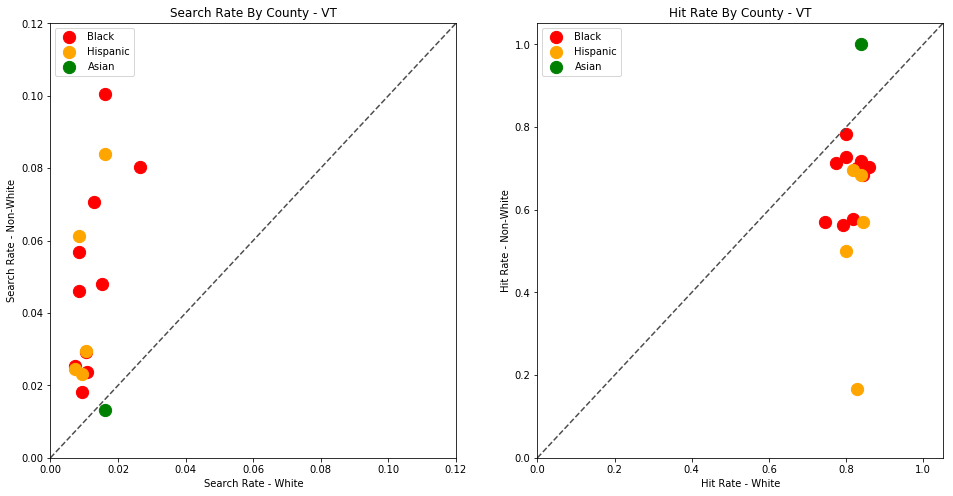

In [35]:
fig = generate_comparison_scatters(df_vt, 'VT')
#fig.savefig('images/search_scatters_VT.png', bbox_inches='tight')


The plots above are comparing `search_rate` (left) and `hit_rate` (right) for minority drivers compared with white drivers in each county.  If all of the dots (each of which represents the stats for a single county and race) followed the diagonal center line, the implication would be that white drivers and non-white drivers are searched at the exact same rate with the exact same standard of evidence.

Unfortunately, this is not the case.  In the above charts, we can see that, for every county, the search rate is higher for Black and Hispanic drivers even though the hit rate is lower.



Let's define one more visualization helper function, to show all of these results on a single scatter plot.


In [36]:
def generate_county_search_stats_scatter(df, state):
    """Generate a scatter plot of search rate vs. hit rate by race and county"""
    race_location_agg = df.groupby(['county_fips','driver_race']).apply(compute_search_stats)

    colors = ['blue','orange','red', 'green']
    fig, ax = plt.subplots(figsize=figsize)
    for c, frame in race_location_agg.groupby('driver_race'):
        ax.scatter(x=frame['hit_rate'], y=frame['search_rate'], s=150, label=c, color=colors.pop())
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=4, fancybox=True)
    ax.set_xlabel('Hit Rate')
    ax.set_ylabel('Search Rate')
    ax.set_title("Search Stats By County and Race - {}".format(state))
    return fig

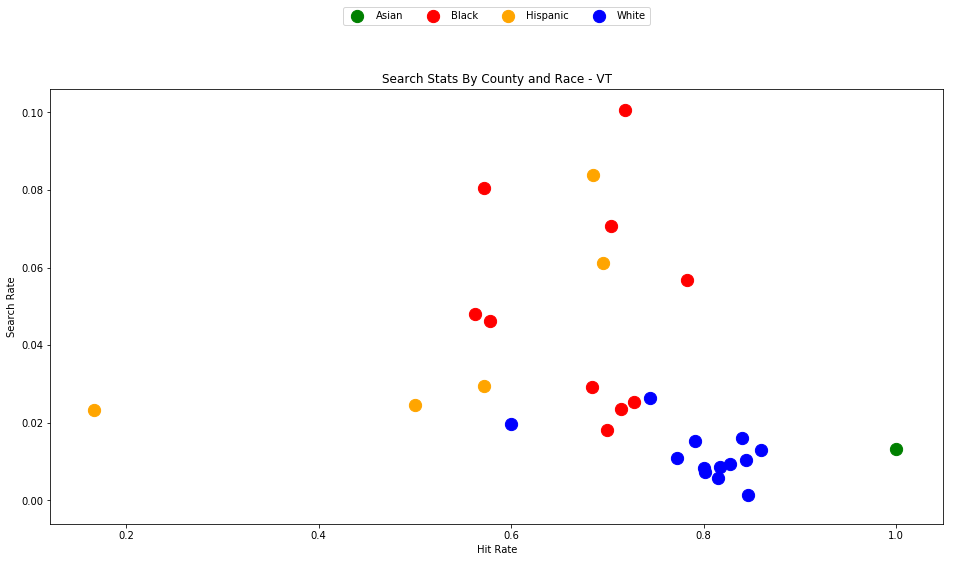

In [37]:
fig = generate_county_search_stats_scatter(df_vt, "VT")
#fig.savefig('images/county_scatter_VT.png', bbox_inches='tight')

As the old idiom goes - *a picture is worth a thousand words*.  The above chart is one of those pictures - and the name of the picture is "Systemic Racism".

The search rates and hit rates for white drivers in most counties are consistently clustered around 80% and 1% respectively.  We can see, however, that nearly every county searches Black and Hispanic drivers at a higher rate, and that these searches uniformly have a lower hit rate than those on White drivers.

This state-wide pattern of a higher search rate combined with a lower hit rate suggests that a lower standard of evidence is used when deciding to search Black and Hispanic drivers compared to when searching White drivers.

> You might notice that only one county is represented by Asian drivers - this is due to the lack of data for searches of Asian drivers in other counties.


# Analyzing Other States

Vermont is a great state to test out our analysis on, but the dataset size is relatively small.  Let's now perform the same analysis on other states to determine if this pattern persists across state lines.

We've developed a solid reusable formula for reading and visualizing each state's dataset, so let's wrap the entire recipe in a new helper function.

In [38]:
fields = ['county_fips', 'driver_race', 'search_conducted', 'contraband_found']
types = {
    'contraband_found': bool,
    'county_fips': float,
    'driver_race': object,
    'search_conducted': bool
}

def analyze_state_data(state):
    df = pd.read_csv('./data/{}-clean.csv.gz'.format(state), compression='gzip', low_memory=True, dtype=types, usecols=fields)
    df.dropna(inplace=True)
    df = df[df['driver_race'] != 'Other']
    
    search_scatters = generate_comparison_scatters(df, state)
    #search_scatters.savefig('images/search_scatters_{}.png'.format(state), bbox_inches='tight')

    county_scatter = generate_county_search_stats_scatter(df, state)
    #county_scatter.savefig('images/county_scatter_{}.png'.format(state), bbox_inches='tight')
    
    return df.groupby('driver_race').apply(compute_search_stats)

We're making a few optimizations here in order to make the analysis a bit more streamlined and computationally efficient.  By only reading the four columns that we're interested in, and by specifying the datatypes ahead of time, we'll be able to read larger datasets into memory more quickly.


## Massachusetts

First we'll generate the analysis for my home state, Massachusetts.  This time we'll have more data to work with - roughly 3.4 million traffic stops.

Download the dataset to your project's `/data` directory - https://stacks.stanford.edu/file/druid:py883nd2578/MA-clean.csv.gz


,hit_rate,n_hits,n_searches,n_stops,search_rate
driver_race,,,,,
Asian,0.331169,357.0,1078.0,101942.0,0.010575
Black,0.487150,4170.0,8560.0,350498.0,0.024422
Hispanic,0.449502,5007.0,11139.0,337782.0,0.032977
White,0.523037,18220.0,34835.0,2527393.0,0.013783


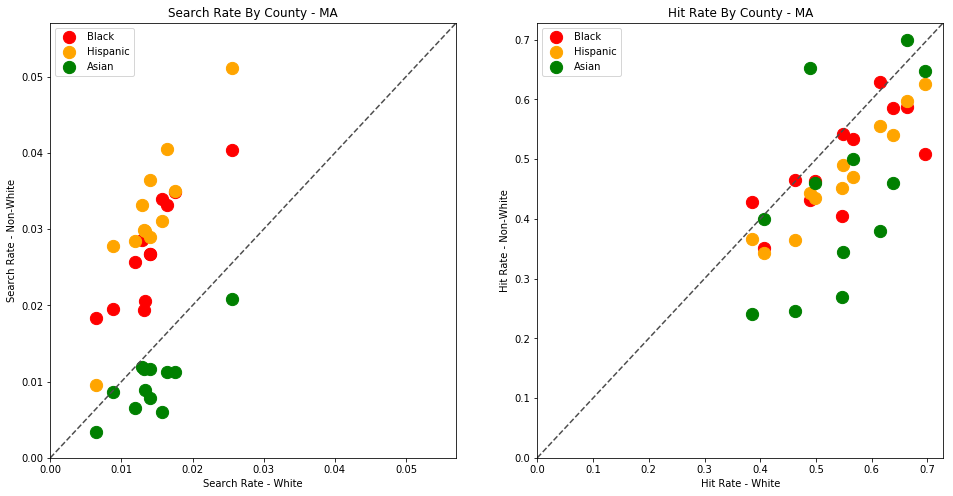

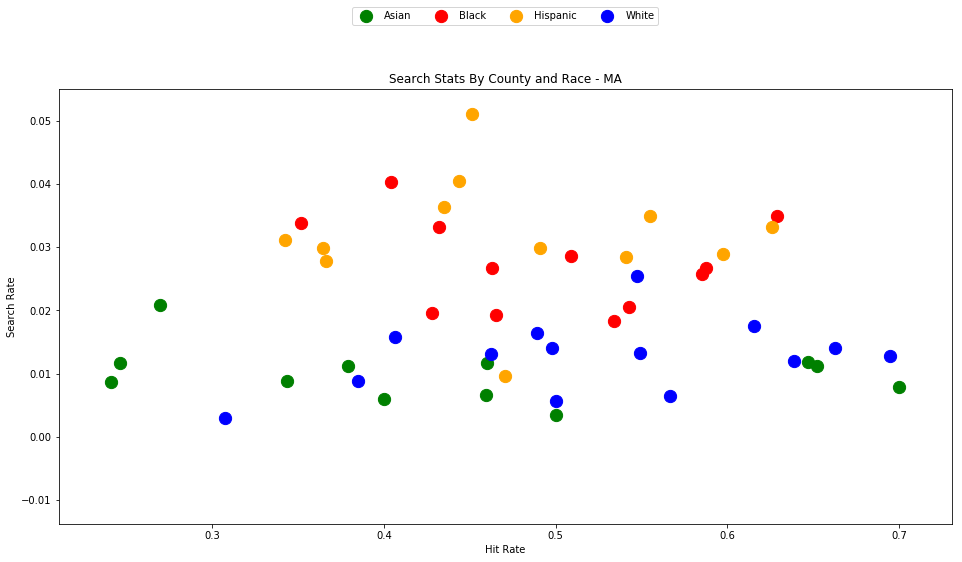

In [39]:
analyze_state_data('MA')

We can see here again that Black and Hispanic drivers are searched at significantly higher rates than white drivers. The differences in hit rates are not as extreme as in Vermont, but they are still noticeably lower for Black and Hispanic drivers than for White drivers.  Asian drivers, interestingly, are the least likely to be searched and also the least likely to have contraband if they are searched.

If we compare the stats for MA to VT, we'll also notice that police in MA seem to use a much lower standard of evidence when searching a vehicle, with their searches averaging around a 50% hit rate, compared to 80% in VT.

The trend here is much less obvious than in Vermont, but it is still clear that traffic stops of Black and Hispanic drivers are more likely to result in a search, despite the fact the searches of White drivers are more likely to result in contraband being found.


## Wisconsin & Connecticut


Wisconsin and Connecticut have been named as some of the [worst states in America for racial disparities](https://www.wpr.org/wisconsin-considered-one-worst-states-racial-disparities).  Let's see how their police stats stack up.

Again, you'll need to download the Wisconsin and Connecticut dataset to your project's `/data` directory.

- Wisconsin: https://stacks.stanford.edu/file/druid:py883nd2578/WI-clean.csv.gz
- Connecticut: https://stacks.stanford.edu/file/druid:py883nd2578/WI-clean.csv.gz


We can call our `analyze_state_data` function for Wisconsin once the dataset has been downloaded.


/Users/patrick/Library/Python/3.6/lib/python/site-packages/IPython/core/interactiveshell.py:2808: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


,hit_rate,n_hits,n_searches,n_stops,search_rate
driver_race,,,,,
Asian,0.470817,121.0,257.0,24577.0,0.010457
Black,0.477574,1299.0,2720.0,56050.0,0.048528
Hispanic,0.415741,449.0,1080.0,35210.0,0.030673
White,0.526300,5103.0,9696.0,778227.0,0.012459


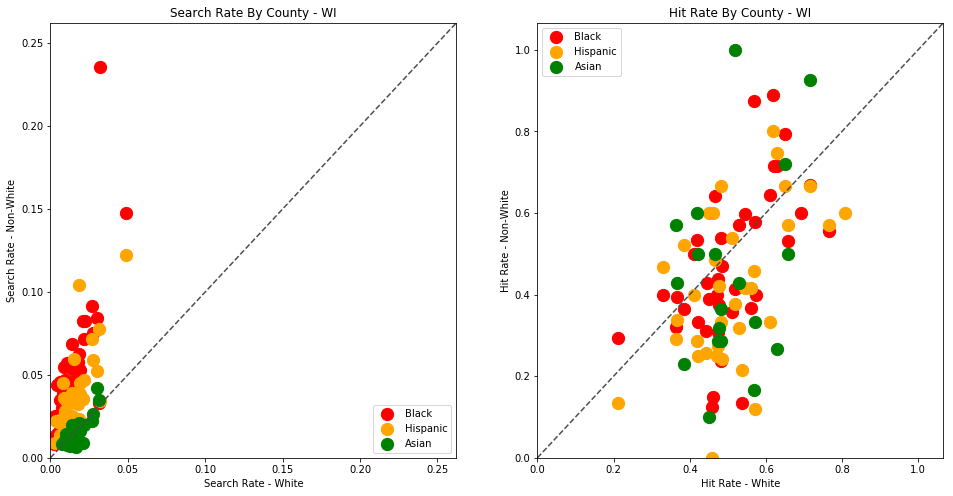

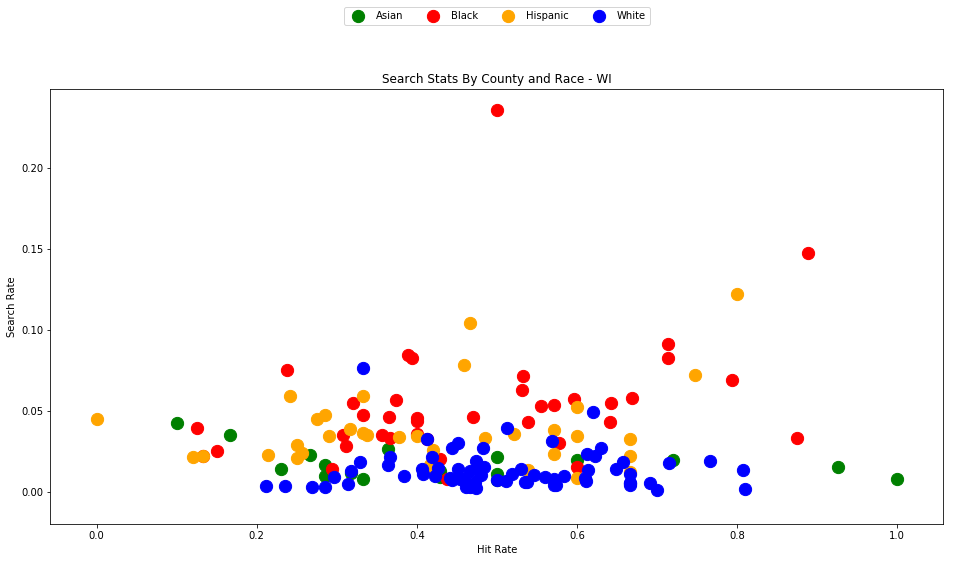

In [40]:
analyze_state_data('WI')

The trends here are starting to look familiar.  White drivers in Wisconsin are much less likely to be searched than non-white drivers (aside from Asians, who tend to be searched at around the same rates as whites).  Searches of non-white drivers are, again, less likely to yield contraband than searches on white drivers.

We can see here, yet again, that the standard of evidence for searching Black and Hispanic drivers is lower in virtually every county than for White drivers.  In one outlying county, almost 25% (!) of traffic stops for Black drivers resulted in a search, even though only half of those searches yielded contraband.


Let's do the same analysis for Connecticut


,hit_rate,n_hits,n_searches,n_stops,search_rate
driver_race,,,,,
Asian,0.384615,10.0,26.0,5949.0,0.004370
Black,0.284072,346.0,1218.0,37460.0,0.032515
Hispanic,0.291925,282.0,966.0,31154.0,0.031007
White,0.379344,1179.0,3108.0,242314.0,0.012826


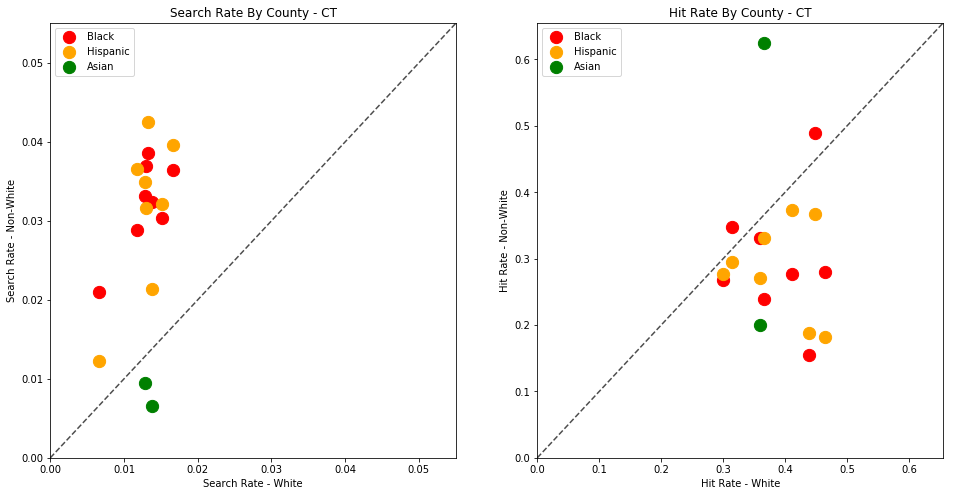

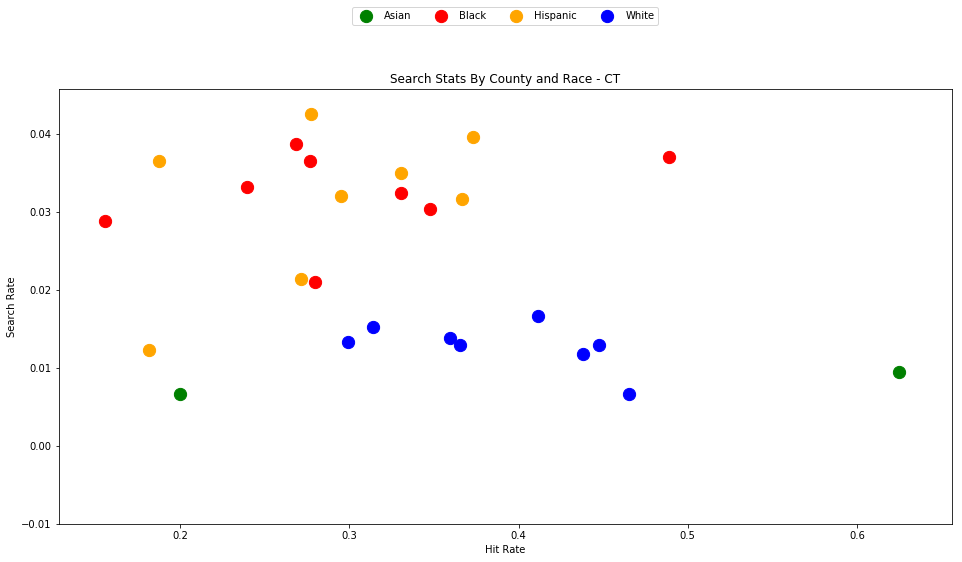

In [41]:
analyze_state_data('CT')

Again, the pattern persists.


## Arizona

We can generate each result rather quickly for each state (with available data), once we've downloaded each dataset.


/Users/patrick/Library/Python/3.6/lib/python/site-packages/IPython/core/interactiveshell.py:2808: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


,hit_rate,n_hits,n_searches,n_stops,search_rate
driver_race,,,,,
Asian,0.196664,224.0,1139.0,48177.0,0.023642
Black,0.255548,2188.0,8562.0,116795.0,0.073308
Hispanic,0.160930,5943.0,36929.0,501619.0,0.073620
White,0.242564,9288.0,38291.0,1212652.0,0.031576


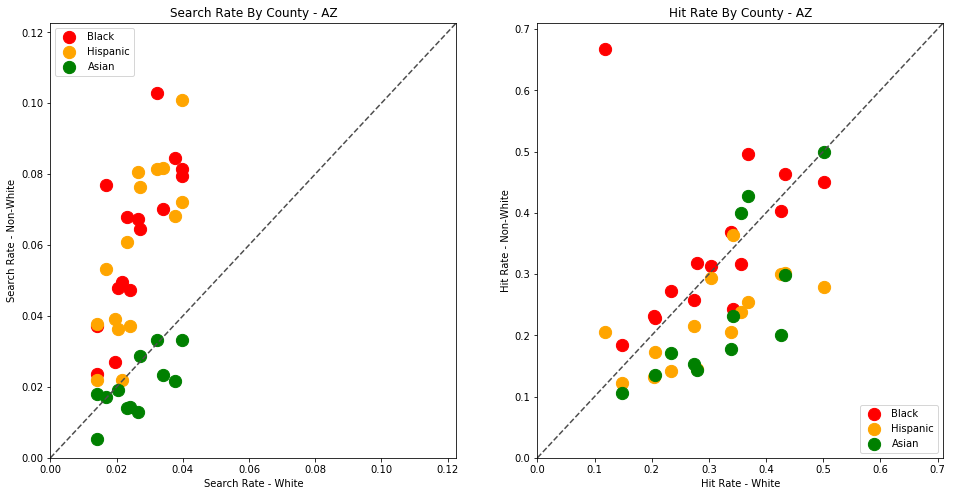

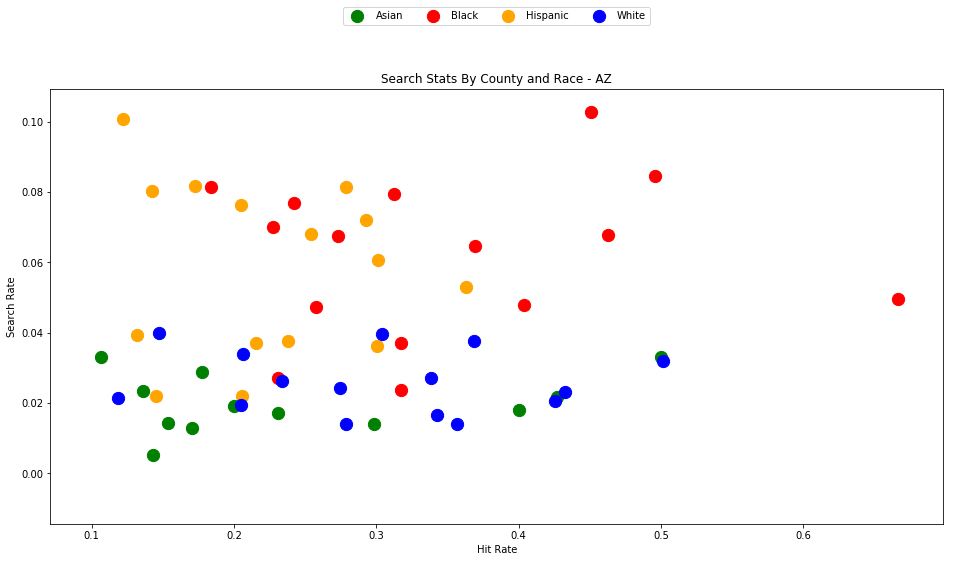

In [42]:
analyze_state_data('AZ')

## Colorado

/Users/patrick/Library/Python/3.6/lib/python/site-packages/IPython/core/interactiveshell.py:2808: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


,hit_rate,n_hits,n_searches,n_stops,search_rate
driver_race,,,,,
Asian,0.537634,50.0,93.0,32471.0,0.002864
Black,0.481283,270.0,561.0,71965.0,0.007795
Hispanic,0.450454,1041.0,2311.0,308499.0,0.007491
White,0.651388,3638.0,5585.0,1767804.0,0.003159


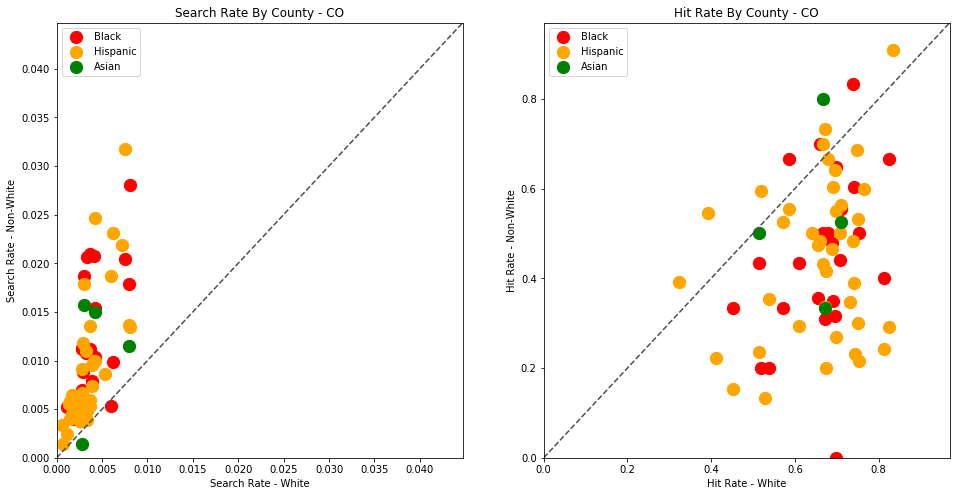

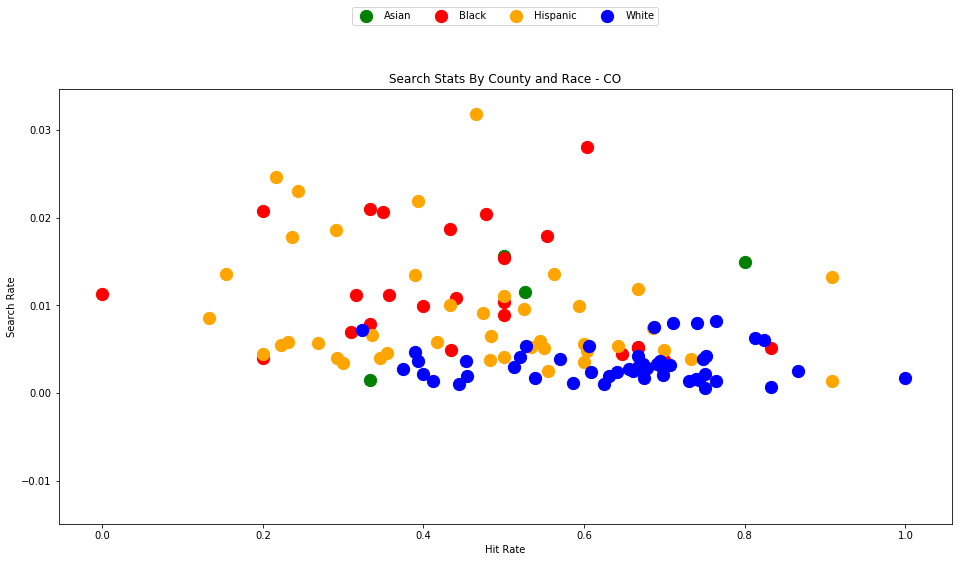

In [43]:
analyze_state_data('CO')

## North Carolina

,hit_rate,n_hits,n_searches,n_stops,search_rate
driver_race,,,,,
Asian,0.104377,31.0,297.0,46287.0,0.006416
Black,0.182489,1955.0,10713.0,1222533.0,0.008763
Hispanic,0.119330,776.0,6503.0,368878.0,0.017629
White,0.153850,3387.0,22015.0,3146302.0,0.006997


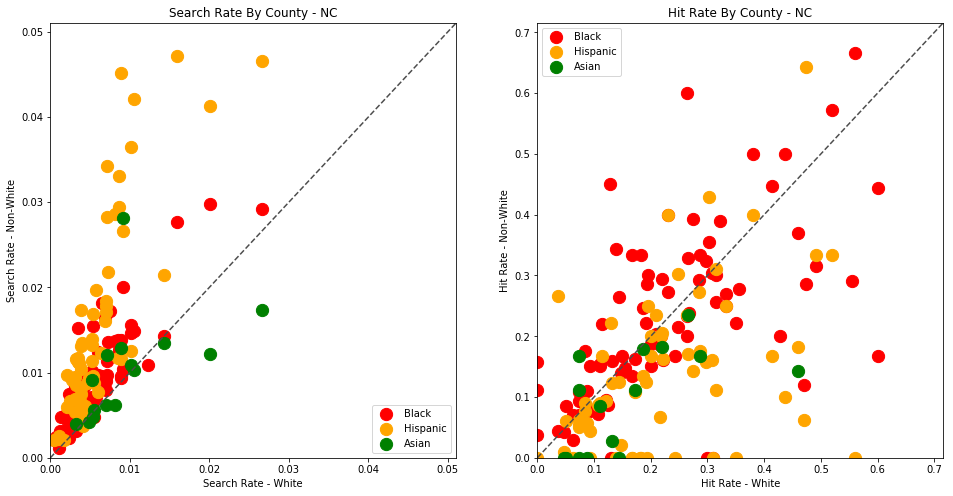

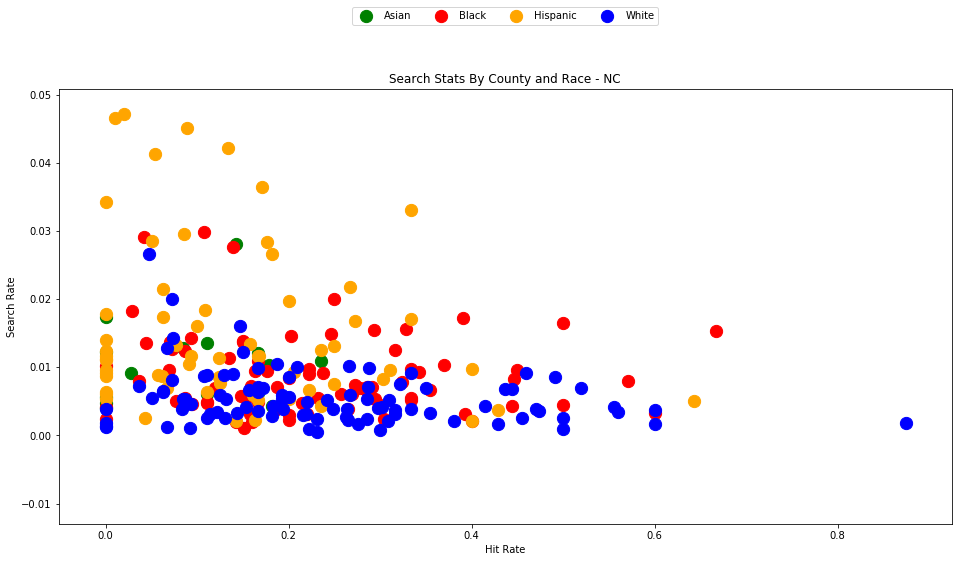

In [44]:
analyze_state_data('NC')

## Washington

,hit_rate,n_hits,n_searches,n_stops,search_rate
driver_race,,,,,
Asian,0.087143,608.0,6977.0,352063.0,0.019817
Black,0.130799,1717.0,13127.0,254577.0,0.051564
Hispanic,0.103366,2128.0,20587.0,502254.0,0.040989
White,0.156008,15768.0,101072.0,4279273.0,0.023619


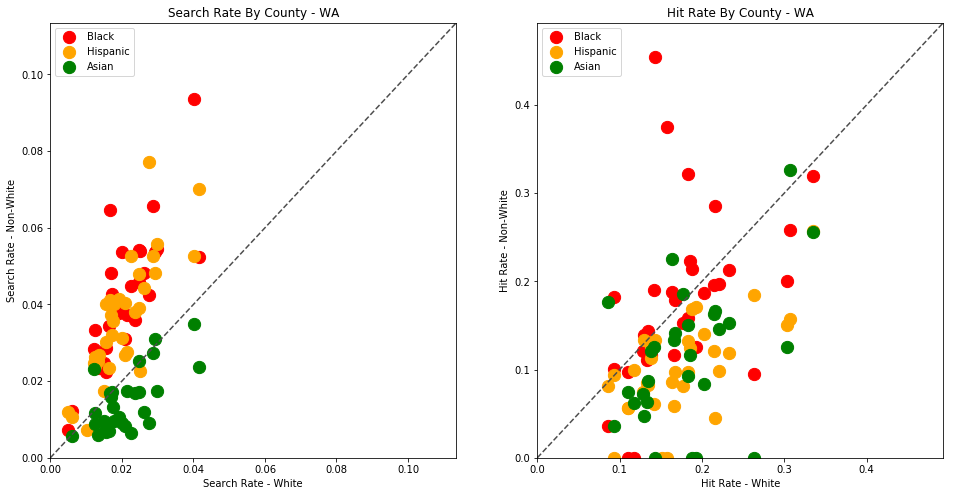

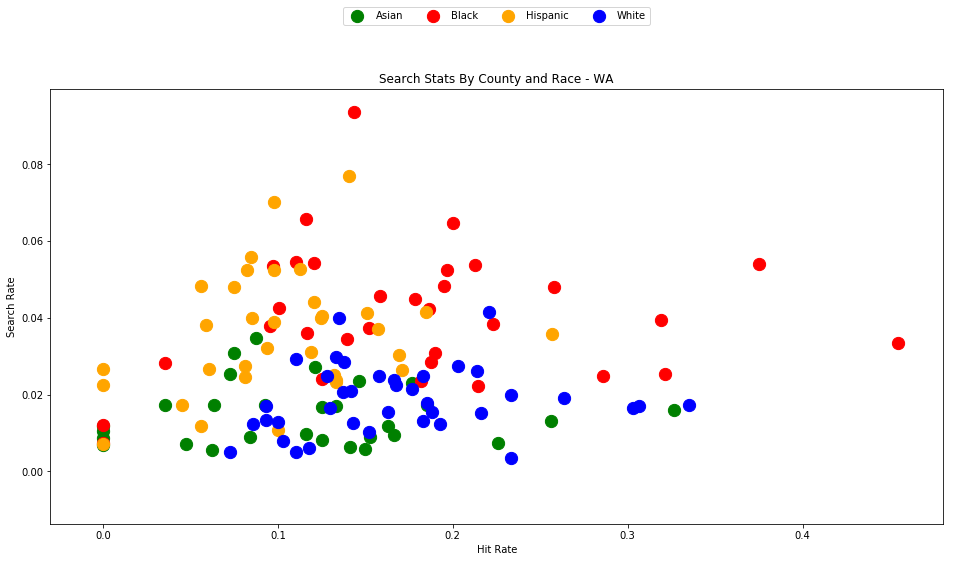

In [45]:
analyze_state_data('WA')

## Texas

You might want to let this one run while you go fix yourself a cup of coffee or tea.  At almost 24 million traffic stops, the Texas dataset takes a rather long time to process.


/Users/patrick/Library/Python/3.6/lib/python/site-packages/IPython/core/interactiveshell.py:2808: DtypeWarning: Columns (16,19) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


,hit_rate,n_hits,n_searches,n_stops,search_rate
driver_race,,,,,
Asian,0.289271,976.0,3374.0,349105.0,0.009665
Black,0.345983,27588.0,79738.0,2300427.0,0.034662
Hispanic,0.219449,37080.0,168969.0,6525365.0,0.025894
White,0.335098,83157.0,248157.0,13576726.0,0.018278


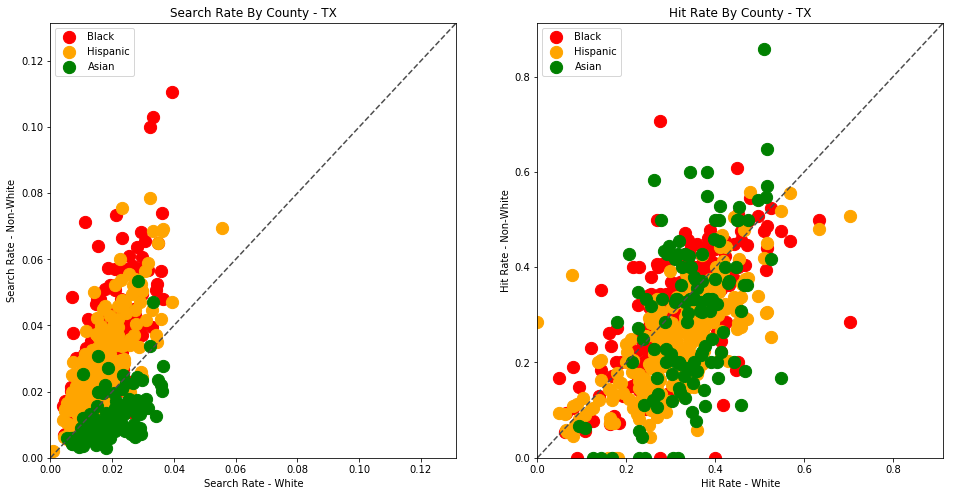

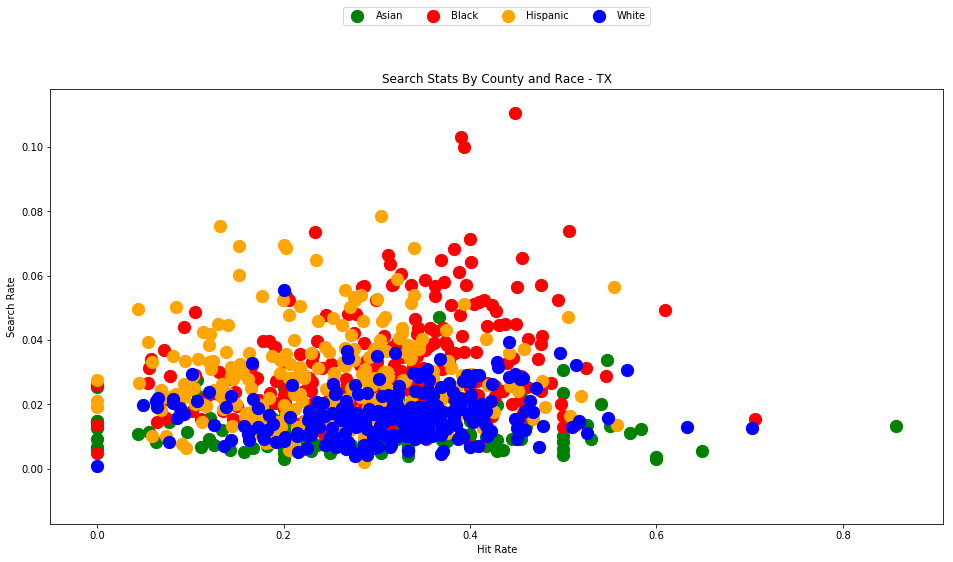

In [46]:
analyze_state_data('TX')

## Even more data visualizations



I highly recommend that you visit the [Standford Open Policing Project results page](https://openpolicing.stanford.edu/findings/) for more visualizations of this data.  Here you can browse the search outcome results for all available states, and explore additional analysis that the researchers have performed such as stop rate by race (using county population demographics data) as well as the effects of recreational marijuana legalization on search rates.


# What next?

Do these results imply that police officers are overtly racist?  **No.**

Do they show that Black and Hispanic drivers are searched much more frequently than white drivers, often with a lower standard of evidence?  **Yes.**

What we are observing here appears to be a pattern of systemic racism.  The racial disparities revealed in this analysis are a reflection of an entrenched mistrust of certain minorities in the United States.  The data and accompanying analysis are indicative of social trends that are certainly not limited to police officers, and *should not be used to disparage this profession as a whole*.  Racial discrimination is present at all levels of society from [retail stores](https://www.theguardian.com/us-news/2015/jun/22/zara-reports-culture-of-favoritism-based-on-race) to the [tech industry](https://www.wired.com/story/tech-leadership-race-problem/) to [academia](https://www.scientificamerican.com/article/sex-and-race-discrimination-in-academia-starts-even-before-grad-school/).

We are able to empirically identify these trends only because state police deparments (and the Open Policing team at Stanford) have made this data available to the public; no similar datasets exist for most other professions and industries.  Releasing datasets about these issues is commendable (but sadly still somewhat uncommon, especially in the private sector) and will help to further identify where these disparities exist, and to influence policies in order to provide a fair, effective way to counteract these biases.

To see the full official analysis for all 20 available states, check out the official findings paper here - https://5harad.com/papers/traffic-stops.pdf.

I hope that this tutorial has provided the tools you might need to take this analysis further.  There's a *lot* more that you can do with the data than what we've covered here.

- Analyze police stops for your home state and county (if the data is available).  If the data is not available, submit a formal request to your local representatives and institutions that the data be made public.
- Combine your analysis with US census data on the demographic, social, and economic stats about each county.
- Create a web app to display the county trends on an interactive map.
- Build a mobile app to warn drivers when they're entering an area that appears to be more distrusting of drivers of a certain race.
- Open-source your own analysis, spread your findings, seek out peer review, maybe even write an explanatory blog post.

The source code and figures for this analysis can be found in the companion Github repository - https://github.com/triestpa/Police-Analysis-Python

To view the completed IPython notebook, visit the page [here](https://github.com/triestpa/Police-Analysis-Python/blob/master/traffic_stop_analysis.ipynb).

The code for this project is 100% open source ([MIT license](https://github.com/triestpa/Police-Analysis-Python/blob/master/LICENSE)), so feel free to use it however you see fit in your own projects.